In [1]:
import numpy as np

dyn_lorenz = {"sigma":16.0, "R":45.92, "b": 4.0}
dyn_henon = {"a": 1.4, "b": 0.3}
x0_henon = np.array([0.0, 0.0])
x0 = np.array([10.0, 1.0, 0.0])

def lorenz (x0, dyn):
    sigma = dyn['sigma']
    R = dyn['R']
    b = dyn['b']
    x = x0[0]
    y = x0[1]
    z = x0[2]
    return np.array([sigma * (y - x), x * (R - z) - y, x * y - b * z])


def RungeKutta (dyn, f, dt, x0):
    k1 = f(x0, dyn)*dt #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1,dyn)*dt
    k3 = f(x0 + 0.5*k2, dyn)*dt
    k4 = f(x0 + k3, dyn)*dt
    
    x = x0 + (k1 + 2*k2 + 2*k3 + k4)/6
    return x

def f_t (dyn, f, dt, x0, T):
    x = np.empty(shape=(len(x0),T))
    print(x.shape)      
    for i in range(1,T):
        x[:, i] = RungeKutta(dyn, f, dt, x[:, i-1]) 
    return x




In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = f_t(dyn_lorenz, lorenz, 0.001, x0, 100000)


(3, 100000)


/tmp/ipykernel_4364/1193619764.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


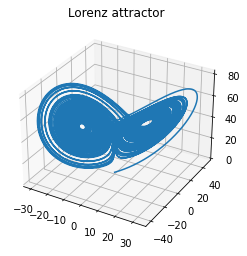

In [57]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(x[0], x[1], x[2])
plt.title('Lorenz attractor')
plt.draw()
plt.savefig('Lorenz_attractor.png')

In [89]:
IND = 0
SUM = 0.0
ITS = 0
IND2 = 0

DI = 1.e38 #any large number

NPT = len(x[0])
DIM = 3 #is dimension 12 ?
dt = 0.001
TAU_physical = 1.5 #no TAU if full state
TAU = int(TAU_physical/dt)
SCALMX = 20
SCALMN = 10
EVOLV_physical = 1.5*2 #time from t0 to t1
EVOLV = int(EVOLV_physical/dt)

In [90]:
NPT = NPT - DIM*TAU - EVOLV

In [91]:
Z = np.empty([NPT,DIM])

In [92]:
#Z(I,J)=JTH COMPONENT OF ITH RECONSTRUCTED ATTRACTOR POINT
#Z(I,J) = X(I+(J-1)*TAU)
#tau = k*dt
for i in range(int(NPT)):
    for j in range(DIM):
        #Z[i][j-1] = x[0][i + (j-1)*TAU]
        #Z[i][j] = x[0][int(int((i*dt + (j-1)*dt*TAU))/dt)]
        Z[i][j] = x[0][i + (j-1)*TAU]

/tmp/ipykernel_4364/1535768772.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


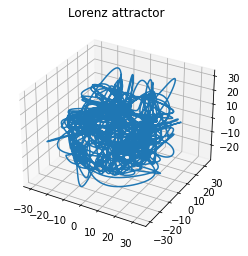

In [93]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(Z[:,0], Z[:,1], Z[:,2])
plt.title('Lorenz attractor')
plt.draw()

In [94]:
#find nearest neighbor to the first data point
for i in range(1, int(NPT)):
    D = 0.0
    #iterate through the array, compare first point with the rest
    D = np.linalg.norm(Z[IND] - Z[i])
    if ((D<DI) and (D>=SCALMN)):
        DI = D
        IND2 = i

In [98]:
IND2 + EVOLV

95178

In [99]:
NPT

92500

In [96]:
SUM_list = []
while ((IND + EVOLV < NPT) and (IND2 + EVOLV < NPT)): #40
    PT1 = Z[IND+EVOLV] #would this be the dimesion
    PT2 = Z[IND2+EVOLV]
    DF = np.linalg.norm(PT1 - PT2)
    ITS = ITS + 1
    SUM_list.append(SUM)
    SUM = SUM + np.log2(DF/DI)/EVOLV_physical
    ZLYAP = SUM/float(ITS)
    INDOLD = IND2
    ZMULT = 1.0
    ANGLMX = 0.3
    #THMIN = 3.14
    while (True): #70
        #print("here")
        THMIN = 3.14

        for i in range (int(NPT)): #100
            III = int(np.absolute(i-(IND+EVOLV)))
            if (III >= 10):
                #find angular change old to new vector
                DNEW = 0.0
                DNEW = np.linalg.norm(PT1 - Z[i])
                if ((DNEW <= ZMULT*SCALMX) and (DNEW >= SCALMN)):
                    DOT = 0.0
                    DOT = np.dot((PT1 - Z[i]),(PT1 - PT2))
                    CTH = np.absolute(DOT/(DNEW*DF))
                    #print(CTH)
                    if (CTH > 1.0):
                        CTH = 1.0
                    TH = np.arccos(CTH)
                    #save smallest angular change so far
                    if TH <= THMIN:
                        THMIN = TH
                        DII = DNEW
                        IND2 = i
        if (THMIN < ANGLMX):
            #print ("here")
            break
        # look at longer distance if cant find replacement
        ZMULT = ZMULT + 1
        if (ZMULT > 5):
            #no replacement at 5*scale, double search angle, reset distance
            ZMULT = 1.0
            ANGLMX = 2.0*ANGLMX
        if (ANGLMX >= 3.14):
            IND2 = INDOLD + EVOLV
            DII = DF
    IND = IND + EVOLV
    if (IND > NPT):
        print('here')
        break
    print ("IND, IND2, NPT", IND, IND2, NPT)
    DI = DII

In [97]:
SUM_list

[]

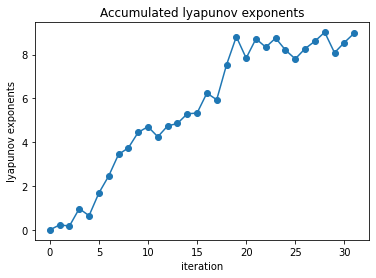

In [31]:
import matplotlib.pyplot as plt

plt.plot(SUM_list)
plt.scatter(range(len(SUM_list)),SUM_list)
plt.title('Accumulated lyapunov exponents')
plt.ylabel('lyapunov exponents')
plt.xlabel('iteration')
plt.savefig('lorez_tau112.png')